# Numbers with uncertainties

The result of a measurement should be given as a number with an attached uncertainties, besides the physical unit, and all operations performed involving the result of the measurement should propagate the uncertainty, taking care of correlation between quantities.

There is a Julia package for dealing with numbers with uncertainties: [`Measurements.jl`](https://github.com/JuliaPhysics/Measurements.jl).  Thanks to Julia's features, `DifferentialEquations.jl` easily works together with `Measurements.jl` out-of-the-box.

This notebook will cover some of the examples from the tutorial about classical Physics.

## Radioactive Decay of Carbon-14

The rate of decay of carbon-14 is governed by a first order linear ordinary differential equation

$$ \frac{\mathrm{d}u(t)}{\mathrm{d}t} = -c u(t) $$

where $c = (5730 \pm 40)$ years is the half-life of carbon-14.

In [1]:
using DifferentialEquations, Measurements, Plots

pyplot()

#Setup
u₀ = 1 ± 0
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -(5.730 ± 0.040)*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u₀,tspan)
sol = solve(prob,Tsit5());

LoadError: [91mMethodError: Cannot `convert` an object of type Measurements.Measurement{Float64} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.[39m

Oh, no, we got an error!

The problem lies in the fact that the extrema of the time interval in which we want to solve the equation, `tspan`, should be of type `Measurement` as well.

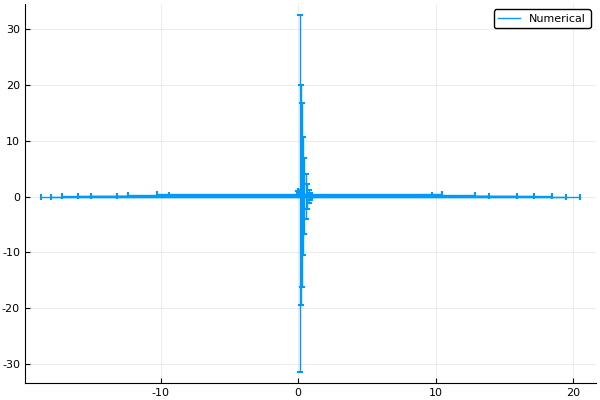

In [2]:
tspan = (0.0 ± 0, 1.0 ± 0)
prob = ODEProblem(radioactivedecay, u₀, tspan)
sol = solve(prob, Tsit5())

plot(sol.t, sol.u, label = "Numerical")

Ok, now it works.  But... wait, those uncertainties look too large!

Yes, here is a subtlety of `Measurements.jl` that you should be aware of:

In [3]:
5.23 ± 0.14 === 5.23 ± 0.14

false

In [4]:
(5.23± 0.14) - (5.23 ± 0.14)

0.0 ± 0.19798989873223333

In [5]:
(5.23 ± 0.14) / (5.23 ± 0.14)

1.0 ± 0.0378565771954557

The two numbers above, even though have the same nominal value and the same uncertainties, are actually two different measurements that only by chance share the same figures and their difference and their ratio have a non-zero uncertainty.  It is common in physics to get very similar, or even equal, results for a repeated measurement, but the two measurements are not the same thing.  This is also the reason why the uncertainty in the solution of the differential equation was so large without apparent reason.

However, if you define a variable:

In [6]:
x = 5.23 ± 0.14

5.23 ± 0.14

In [7]:
x === x

true

In [8]:
x - x

0.0 ± 0.0

In [9]:
x / x

1.0 ± 0.0

we have that `x` is strictly equal to itself and the difference between `x` and itself and its own ratio have zero uncertainty, because there is no doubt about the result of these operations.  It is this feature of `Measurements.jl` that enables it to correctly propagate the uncertainty of numbers accurately taking care of correlation between measurements.  However, you have also to remember it in order not to make mistakes.

### Complete correct version

The only thing we have to do to fix the error is to define a variable equal to the half-life of carbon-14:

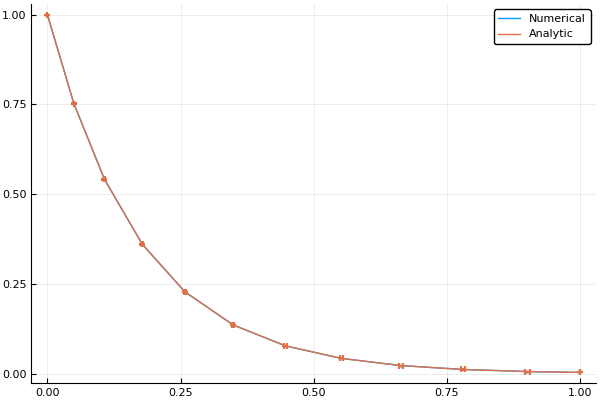

In [10]:
using DifferentialEquations, Measurements, Plots

pyplot()

# Half-life of radiocarbon, in thousands of years
c = 5.730 ± 0.040

#Setup
u₀ = 1 ± 0
tspan = (0 ± 0, 1 ± 0)

#Define the problem
radioactivedecay(u,p,t) = -c * u

#Pass to solver
prob = ODEProblem(radioactivedecay, u₀, tspan)
sol = solve(prob, Tsit5())

# Analytic solution
u = exp.(-c .* sol.t)

plot(sol.t, sol.u, label = "Numerical")
plot!(sol.t, u, label = "Analytic")

The two curves are perfectly superimposed, indicating that the numerical solution matches the analytic one.  We can check that also the uncertainties are correctly propagated in the numerical solution:

In [11]:
println("Quantity of carbon-14 after ",  Measurements.value(sol.t[10]) * 1000, " years:")
println("Numerical: ", sol[10])
println("Analytic:  ", u[10])

Quantity of carbon-14 after 780.1928441944027 years:
Numerical: 0.011442440679072052 ± 5.6531990631848624e-5
Analytic:  0.011441536447079504 ± 5.653148388060455e-5


## Simple pendulum

### Small angles approximation

The next problem we are going to study is the simple pendulum in the approximation of small angles.  We address this simplified case because there exists an easy analytic solution to compare.

The differential equation we want to solve is

$$ \ddot{\theta} + \frac{g}{L} \theta = 0 $$

where $g = (9.79 \pm 0.02)~\mathrm{m}/\mathrm{s}^2$ is the gravitational acceleration measured where the experiment is carried out, and $L = (1.00 \pm 0.01)~\mathrm{m}$ is the length of the pendulum.

When you set up the problem for `DifferentialEquations.jl` remember to define the measurements as variables, as seen above.

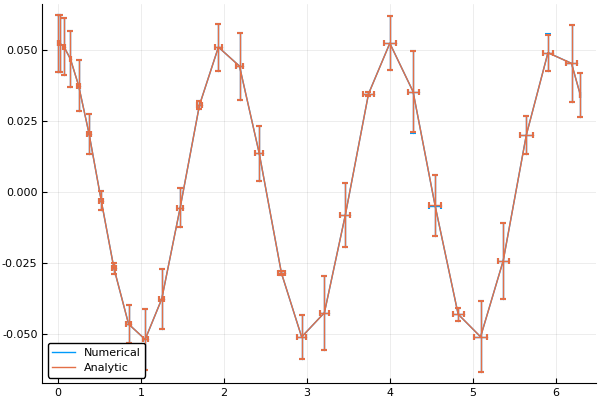

In [12]:
using DifferentialEquations, Measurements, Plots

pyplot()

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

#Initial Conditions
u₀ = [0 ± 0, π / 60 ± 0.01] # Initial speed and initial angle
tspan = (0 ± 0, 6.3 ± 0)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L)*θ
end

#Pass to solvers
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5())

# Analytic solution
u = u₀[2] .* cos.(sqrt(g / L) .* sol.t)

plot(sol.t, getindex.(sol.u, 2), label = "Numerical")
plot!(sol.t, u, label = "Analytic")

Great, this time we got the right result at the first take!  Also in this case there is a perfect superimposition between the two curves, including their uncertainties.

We can also have a look at the difference between the two solutions:

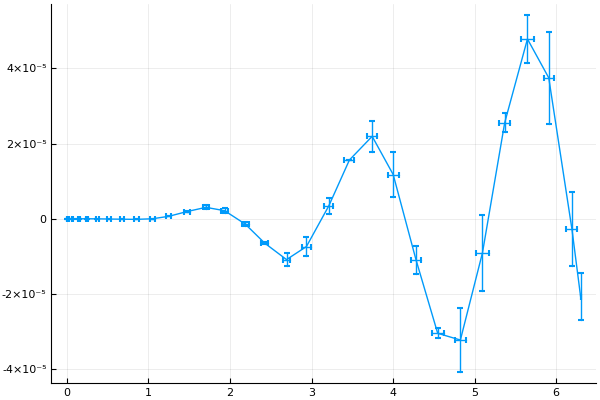

In [13]:
plot(sol. t, getindex.(sol.u, 2) .- u, label = "")

## Arbitrary amplitude

Now that we know how to solve differential equations involving numbers with uncertainties we can solve the simple pendulum problem without any approximation.  This time the differential equation to solve is the following:

$$ \ddot{\theta} + \frac{g}{L} \sin(\theta) = 0 $$

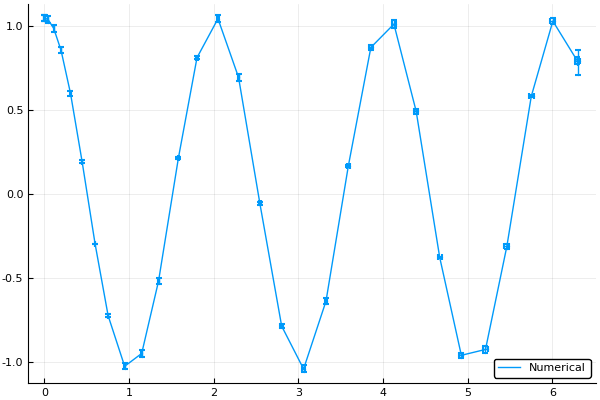

In [14]:
using DifferentialEquations, Measurements, Plots

pyplot()

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

#Initial Conditions
u₀ = [0 ± 0, π / 3 ± 0.02] # Initial speed and initial angle
tspan = (0 ± 0, 6.3 ± 0)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L) * sin(θ)
end

#Pass to solvers
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5())

plot(sol.t, getindex.(sol.u, 2), label = "Numerical")